## Setup

Let's import the necessary modules and dependencies.

In [12]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

- Import the dataset (in the code the dataset loaded from the kaggle's input, you can give the actual path of the dataset also)

In [13]:
data_dir = '/kaggle/input/speech-command-30words-data/Speech_Command_30Words'
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' 'off' 'yes' 'six' 'dog' 'left'
 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree' 'seven' 'on'
 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat' 'sheila']


Let's extract the audio clips into a list named filenames and shuffle it:

In [14]:
import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Assuming `data_dir` and `commands` are defined earlier
filenames = sorted(tf.io.gfile.glob(str(data_dir) + '/*/*'))
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir+'/' + commands[0]))))
print('Example file tensor:', filenames[0])


Number of total examples: 64721
Number of examples per label: 2375
Example file tensor: tf.Tensor(b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/marvin/3389305e_nohash_1.wav', shape=(), dtype=string)


In [15]:
filenames

<tf.Tensor: shape=(64721,), dtype=string, numpy=
array([b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/marvin/3389305e_nohash_1.wav',
       b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/yes/d5ca80c6_nohash_1.wav',
       b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/five/8c7b691a_nohash_0.wav',
       ...,
       b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/right/6cf5459b_nohash_0.wav',
       b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/cat/c5c60d8d_nohash_0.wav',
       b'/kaggle/input/speech-command-30words-data/Speech_Command_30Words/no/d8c314c0_nohash_1.wav'],
      dtype=object)>

Let's split the files into training, validation, and testing sets using an 80:10:10 ratio respectively:

In [16]:
train_files = filenames[:51776]
val_files = filenames[51776: 51776 + 6472]
test_files = filenames[-6472:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 51776
Validation set size 6472
Test set size 6472


## Reading Audio Files and Their Labels

In [17]:
test_file = tf.io.read_file(data_dir+'/down/00176480_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

Now, let's define a function that preprocesses the raw WAV audio files in the dataset into audio tensors:

In [18]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Let's define a function that creates labels using parent directories for each file:

- We'll split paths to files into tf.RaggedTensor (tensors with ragged dimensions - with fragments that can have varying lengths).

In [19]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Let's define another auxiliary function - get_waveform_and_label, which combines two things:

- The input is a sound file name in WAV format.
- The output is a tuple containing audio tensors and labels ready for supervised learning.

In [20]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


Create a training dataset to extract audio-label pairs:

- Create a tf.data.Dataset using Dataset.from_tensor_slices and Dataset.map, using the previously defined get_waveform_and_label.

Later, we'll create datasets for validation and testing using a similar procedure.

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

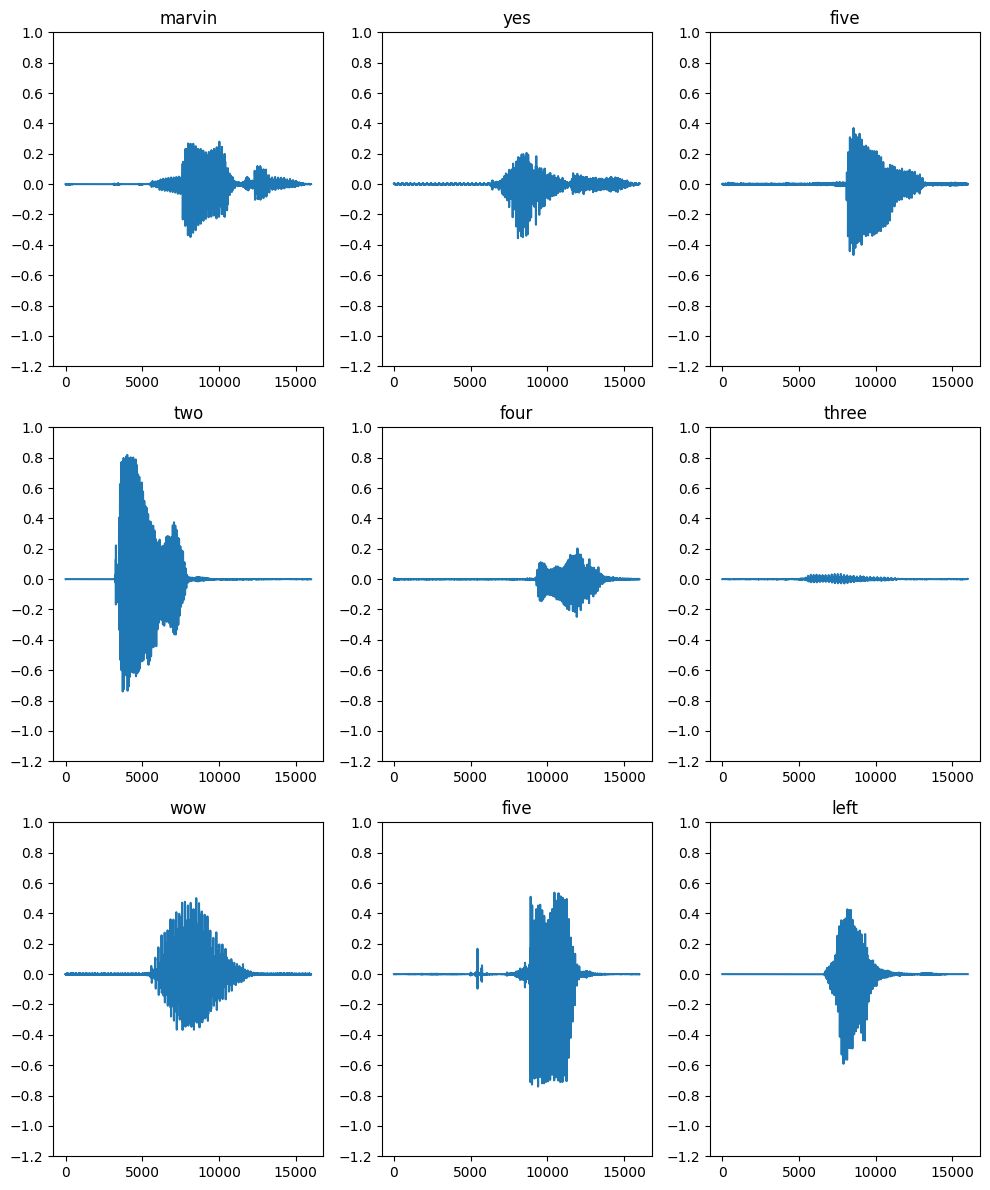

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming waveform_ds is a dataset containing audio waveforms and labels

# Assuming you have defined rows, cols, and n as in your original code

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

# fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [23]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [24]:
for waveform, label in waveform_ds.take(102): # замените число здесь, чтобы увидеть другие примеры записи голоса
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (14118,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [25]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        # Convert the frequencies to log scale and transpose, so that the time is
        # represented on the x-axis (columns).
        # Add an epsilon to avoid taking a log of zero.
        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)

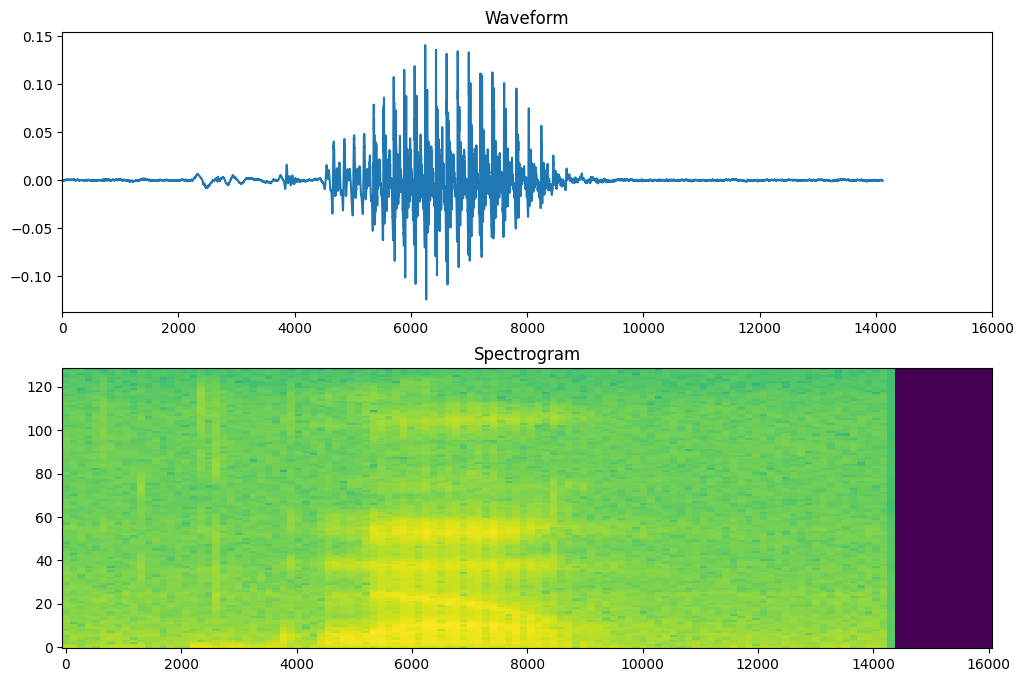

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [27]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [28]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

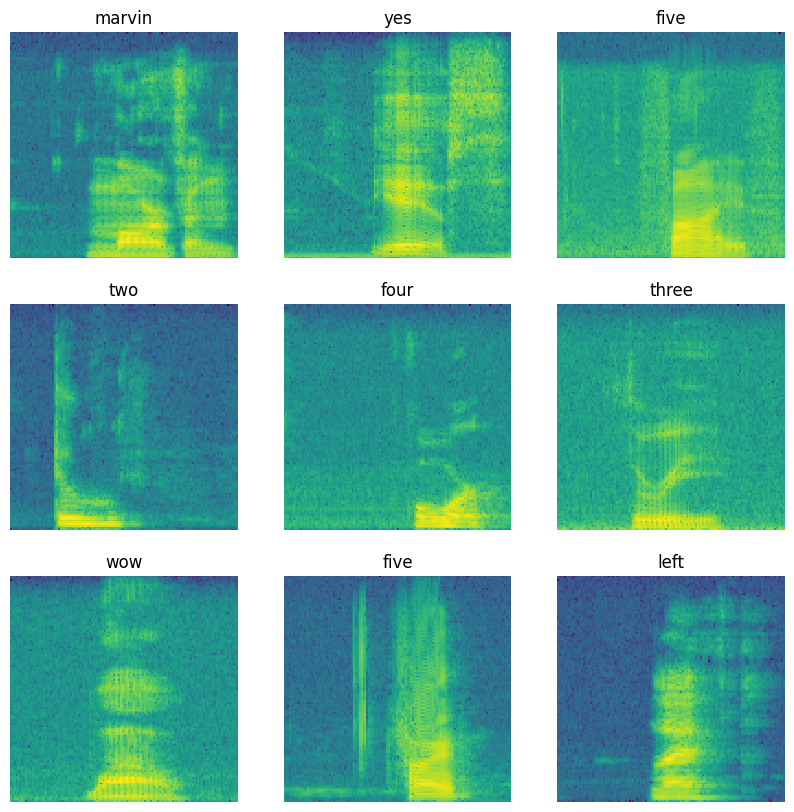

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [30]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [31]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [32]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [33]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [83]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming `spectrogram_ds` is defined earlier
for spectrogram, _ in spectrogram_ds.take(1):
    print('Spectrogram shape:', spectrogram.shape)
input_shape = spectrogram.shape
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
try:
    norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
except Exception as e:
    print("Error during normalization adaptation:", e)

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='tanh'),
    layers.Conv2D(64, 3, activation='tanh'),
    layers.Conv2D(128, 3, activation='tanh'),
    layers.Conv2D(64, 3, activation='tanh'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='tanh'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


Spectrogram shape: (124, 129, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 24, 24, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │         3,870 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,350,113 (5.15 MB)

 Trainable params: 1,350,110 (5.15 MB)

 Non-trainable params: 3 (16.00 B)

In [84]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [85]:
EPOCHS = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)

Epoch 1/50
  7/809 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.0381 - loss: 3.4235

W0000 00:00:1714720802.699507     242 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


807/809 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2910 - loss: 2.4671

W0000 00:00:1714720814.898690     243 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


809/809 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.2914 - loss: 2.4656 - val_accuracy: 0.6324 - val_loss: 1.2554
Epoch 2/50
 13/809 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5807 - loss: 1.4297

W0000 00:00:1714720816.443630     245 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.5804 - loss: 1.4184 - val_accuracy: 0.7183 - val_loss: 0.9786
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6474 - loss: 1.1894 - val_accuracy: 0.7488 - val_loss: 0.8766
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6779 - loss: 1.0915 - val_accuracy: 0.7579 - val_loss: 0.8245
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7043 - loss: 1.0037 - val_accuracy: 0.7695 - val_loss: 0.7757
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7180 - loss: 0.9618 - val_accuracy: 0.7803 - val_loss: 0.7638
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7260 - loss: 0.9287 - val_accuracy: 0.7760 - val_loss: 0.7643
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7351 - loss: 0.9012 - val_accuracy: 0.7942 - val_loss: 0.7156
Epoch 9/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7465 - loss: 0.8663 - val_accurac

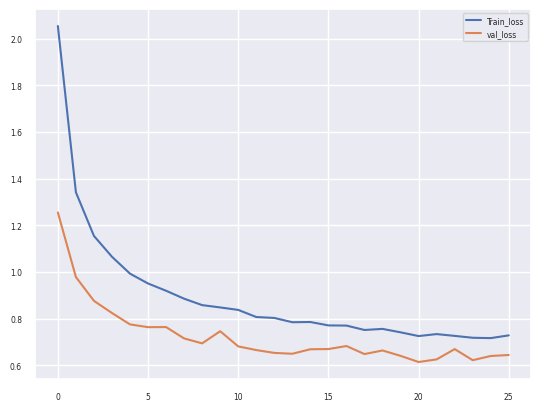

In [96]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['Train_loss', 'val_loss'])

plt.savefig('Train_Val_Loss_4Layer_tanh.png')

plt.show()

In [97]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [98]:
len(test_audio)

6472

In [99]:
test_labels

array([ 3, 29, 13, ...,  5, 28,  0])

In [100]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test set accuracy: 81%


In [101]:
len(commands)

30

In [102]:
# Get the unique values and their counts
unique_values, counts = np.unique(y_true, return_counts=True)

# Print the results
for value, count in zip(unique_values, counts):
    print(f"{value} occurs {count} times")

0 occurs 242 times
1 occurs 220 times
2 occurs 222 times
3 occurs 211 times
4 occurs 241 times
5 occurs 241 times
6 occurs 240 times
7 occurs 237 times
8 occurs 239 times
9 occurs 177 times
10 occurs 233 times
11 occurs 166 times
12 occurs 189 times
13 occurs 253 times
14 occurs 253 times
15 occurs 173 times
16 occurs 231 times
17 occurs 193 times
18 occurs 194 times
19 occurs 236 times
20 occurs 236 times
21 occurs 216 times
22 occurs 230 times
23 occurs 225 times
24 occurs 262 times
25 occurs 216 times
26 occurs 166 times
27 occurs 187 times
28 occurs 154 times
29 occurs 189 times


- Confusion metrics and label wise accuracy

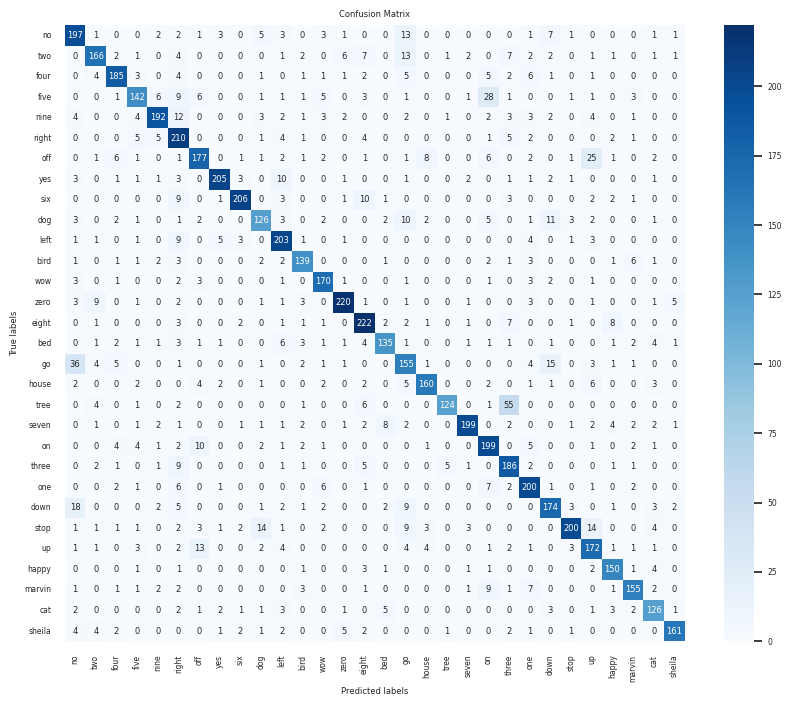

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already defined y_pred and y_true as mentioned in your code

# Define your labels (assuming you have a list of labels)
commands 

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate label-wise accuracy
labelwise_acc = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Print label-wise accuracy
# for i, acc in enumerate(labelwise_acc):
#     print(f'Accuracy for class {i}: {acc:.2%}')

# Plot confusion matrix with seaborn heatmap
plt.figure(figsize=(10,8))
sns.set(font_scale=0.5)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=commands, yticklabels=commands)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')


plt.savefig('confusion_matrix_4Layer_Tanh.png')

plt.show()



# Calculate the overall accuracy using the confusion matrix
# overall_acc = np.trace(conf_matrix) / np.sum(conf_matrix)
# print(f'\nOverall test set accuracy: {overall_acc:.2%}')


In [104]:
import pandas as pd

# Calculate overall accuracy
overall_acc = np.trace(conf_matrix) / np.sum(conf_matrix)

# Calculate label-wise accuracy
labelwise_acc = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)

# Calculate precision, recall, and F1 score for each class
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Create a DataFrame
metrics_df = pd.DataFrame({'Class': commands, 'Label-wise Accuracy': labelwise_acc, 
                           'Precision': precision, 'Recall': recall, 'F1 Score': f1_score})

# Add overall accuracy column
metrics_df['Overall Accuracy'] = overall_acc

# Print the DataFrame
print(metrics_df)


     Class  Label-wise Accuracy  Precision    Recall  F1 Score  \
0       no             0.814050   0.703571  0.814050  0.754789   
1      two             0.754545   0.825871  0.754545  0.788599   
2     four             0.833333   0.852535  0.833333  0.842825   
3     five             0.672986   0.802260  0.672986  0.731959   
4     nine             0.796680   0.884793  0.796680  0.838428   
5    right             0.871369   0.673077  0.871369  0.759494   
6      off             0.737500   0.800905  0.737500  0.767896   
7      yes             0.864979   0.923423  0.864979  0.893246   
8      six             0.861925   0.932127  0.861925  0.895652   
9      dog             0.711864   0.763636  0.711864  0.736842   
10    left             0.871245   0.786822  0.871245  0.826884   
11    bird             0.837349   0.832335  0.837349  0.834835   
12     wow             0.899471   0.841584  0.899471  0.869565   
13    zero             0.869565   0.905350  0.869565  0.887097   
14   eight

In [105]:
metrics_df.to_excel('Metrics_Guj_Digits_4_Layer_Tanh.xlsx')



# Save the model
model.save("Guj_Digits_4_Layer_Tanh.h5")

## "Execute the output of the audio file.

Finally, let's check the result of the model prediction using an input audio file in which someone says 'no'. How well does your model work?"

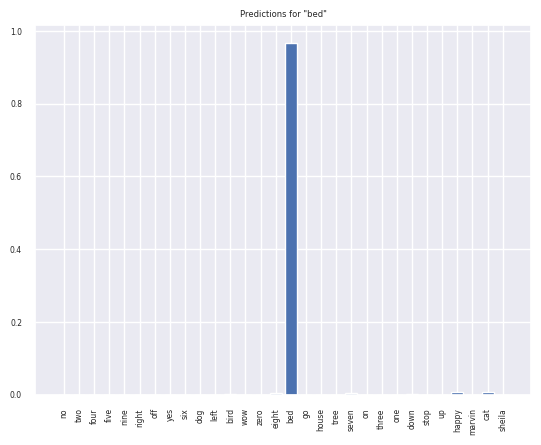

In [106]:
sample_file = '/kaggle/input/speech-command-30words-data/Speech_Command_30Words/bed/00176480_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.xticks(rotation=90)
  plt.show()

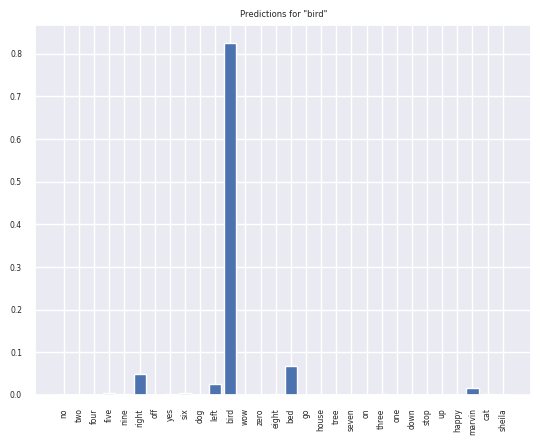

In [109]:
sample_file = '/kaggle/input/speech-command-30words-data/Speech_Command_30Words/bird/00f0204f_nohash_2.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.xticks(rotation=90)
  plt.show()